<a href="https://colab.research.google.com/github/danielapavas/Labs-Deep-Learning/blob/main/content/U5%20LAB%2002%20-%20Padding%2C%20Masking%20-%20Sentiment%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB 5.2 - Padding - Masking

In [3]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()

In [40]:
from local.lib.rlxmoocapi import submit, session
import inspect
session.LoginSequence(endpoint=init.endpoint, course_id=init.course_id, lab_id="L05.02", varname="student");

logging in as daniela.pavas1@udea.edu.co... please wait

-------------
using course session 2021.deeplearning::udea.20242
success!! you are logged in
-------------


In [5]:
!pip install tensorflow==2.15

In [6]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
import tensorflow as tf
tf.__version__

setting tensorflow version in colab
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


'2.15.0'

In [7]:
#Basic required libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

#### The aim of this lab is to build a system for sentiment analysis on a dataset of tweets.

The data consist on passenger's reviews of U.S. airlines: https://www.kaggle.com/crowdflower/twitter-airline-sentiment

In [8]:
data = pd.read_csv('local/data/Tweets.csv')
# Keeping only the neccessary columns
data = data[['text','airline_sentiment']]

In [9]:
data

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
...,...,...
14635,@AmericanAir thank you we got on a different f...,positive
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative
14637,@AmericanAir Please bring American Airlines to...,neutral
14638,"@AmericanAir you have my money, you change my ...",negative


In [10]:
import re
pd.options.mode.chained_assignment = None  # default='warn'
#Remove neutral class
data = data[data.airline_sentiment != "neutral"]

#text normalization
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x:re.sub('@[^\s]+','',x)))#remove the name of the airline
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
Np = np.sum(data['airline_sentiment'].values == 'positive')
Nn = np.sum(data['airline_sentiment'].values == 'negative')
print(f'Number of positive samples={Np}')
print(f'Number of negative samples={Nn}')
for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')

Number of positive samples=2363
Number of negative samples=9178


<ipython-input-10-c0497574ebeb>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row[0] = row[0].replace('rt',' ')
<ipython-input-10-c0497574ebeb>:15: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  row[0] = row[0].replace('rt',' ')


In [11]:
data

,text,airline_sentiment
1,plus youve added commercials to the experienc...,positive
3,its really aggressive to blast obnoxious ente...,negative
4,and its a really big bad thing about it,negative
5,seriously would pay 30 a flight for seats tha...,negative
6,yes nearly every time i fly vx this ear worm ...,positive
...,...,...
14633,my flight was cancelled flightled leaving tom...,negative
14634,right on cue with the delays,negative
14635,thank you we got on a different flight to chi...,positive
14636,leaving over 20 minutes late flight no warnin...,negative


In [12]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
# Removing Stop Words
from nltk.corpus import stopwords
all_sentences = data['text'].values
all_words = [nltk.word_tokenize(sent) for sent in all_sentences]
stop_words = stopwords.words('english')
stop_words.append('')

for i in range(len(all_words)):
    all_words[i] = [w for w in all_words[i] if (w not in stop_words) and (not w.isdigit())]

## Task 1

all_words is a list with all the tweets that are going to be used to train the model. Create a function 'get_preprocessed_seq' that build and apply a Tokenizer to the a list like all_words. Tokenizer must define a dictionary of 2000 words (remeber that position 0 is reserved). Once the sentences are tokenized, take into account that the length of every tweet is different so before they can be passed to the training step, the tweets must be **padded** in order to provide them with equal length. The function 'get_preprocessed_seq' must return the Tokenizer object and the padded dataset.

Review the [padding function](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) in the preprocessing module of keras.

In [23]:
def get_preprocessed_seq(text_list):
    from tensorflow.keras.preprocessing.text import Tokenizer as TK
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    max_words = 2000
    num_words = max_words + 1

    tokenizer = TK(num_words=num_words)
    tokenizer.fit_on_texts(text_list)

    sequences = tokenizer.texts_to_sequences(text_list)
    Xdata = pad_sequences(sequences, padding='post')

    return tokenizer, Xdata

Test your function:

In [24]:
text_list = ['Are random sentences computer generated?',
             'Can I use these random sentences for my project?',
             'Can I write random sentences?']
t,x = get_preprocessed_seq(text_list)

You should get the following results:

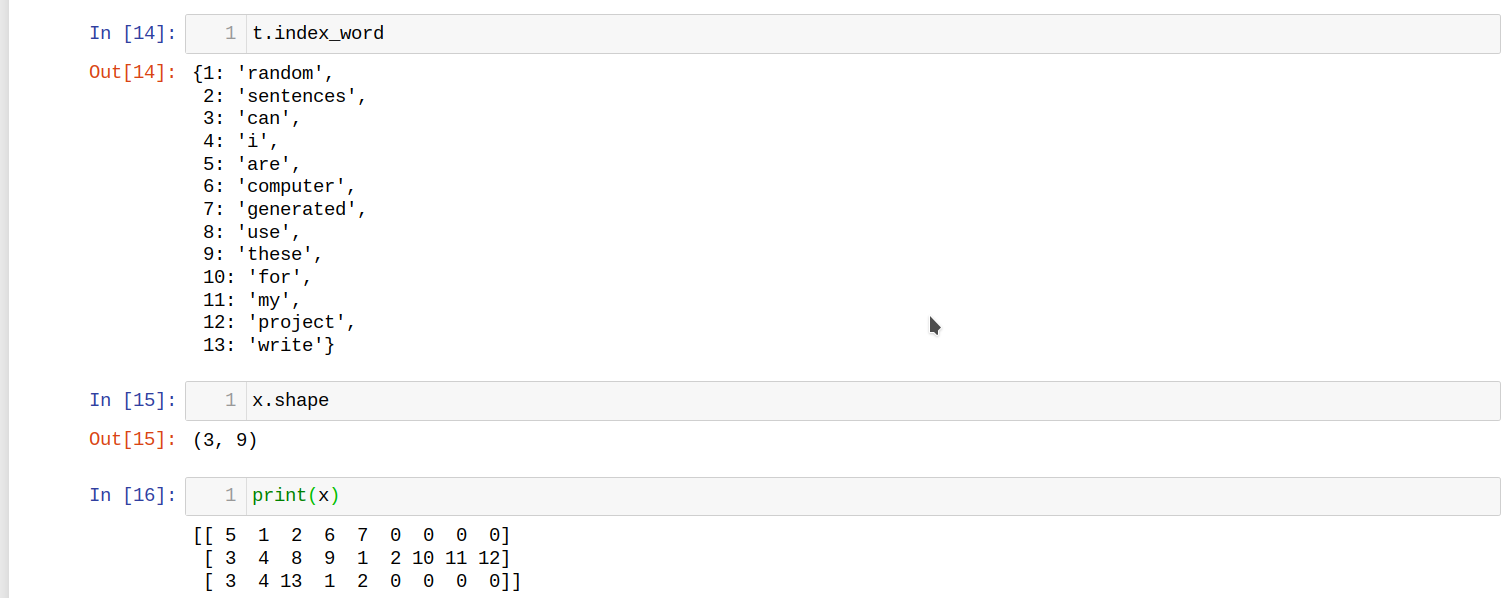

In [25]:

from IPython.display import Image
Image(filename='local/imgs/tokenizer_padding.png', width=600)


**Submit your solution:**

In [26]:
student.submit_task(namespace=globals(), task_id='T1');

## Task 2

The previous step add 0's to some tweets in order to set them with the same length. Now it is necessary to define a model that be able to discard those 0's. Review the masking layer and masking option of the embedding layer of keras. Take a look to the TensorFlow [documentation](https://www.tensorflow.org/guide/keras/masking_and_padding).

Create a function to define a RNN architecture for the sentiment analysis problem. Use the Embedding layer and its masking option to discard the 0's added during padding step. The architecture must consist of a RNN layer with a 'cells_number' of neurons, a dense hidden layer of 10 neurons and the output layer. Include a Dropout layer in between the dense layers with a drop rate of 0.3 . The type of RNN layer must be defined through a 'layer_type' parameter; the embedding dimension must also be set as an input parameter. The activation function for 'SimpleRNN' must be set to 'relu', while for LSTM and GRU a default 'tanh' must be chosen instead.

In [54]:
def Recurrent_Model(cells_number = 10, layer_type='SimpleRNN',Embeb_dim=32):#Options for layer_type: 'SimpleRNN', 'LSTM', 'GRU'
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=2001, output_dim=Embeb_dim, mask_zero=True))
    model.add(tf.keras.layers.Masking(mask_value=0.0))

    if layer_type == 'SimpleRNN':
        model.add(tf.keras.layers.SimpleRNN(units=cells_number, activation='relu'))
    elif layer_type == 'LSTM':
        model.add(tf.keras.layers.LSTM(units=cells_number, activation='tanh'))
    elif layer_type == 'GRU':
        model.add(tf.keras.layers.GRU(units=cells_number, activation='tanh'))

    model.add(tf.keras.layers.Dense(10, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])
    model.summary()

    return model

**Submit your solution:**

In [28]:
student.submit_task(namespace=globals(), task_id='T2');

### Let's test the model:

**Warning**: Run this part only if you have already passed Tasks 1 and 2.

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import recall_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

tokenizer, NewX = get_preprocessed_seq(all_words)

y = data['airline_sentiment'].values
Encoder = LabelEncoder()
Y = Encoder.fit_transform(y)
#Y = Encoder.transform(y)


X_tr, X_te, y_tr, y_te = train_test_split(NewX, Y, test_size=0.2, random_state=2018)

In [32]:
def especi_score(y_te,y_pred):
    Ns = np.sum(y_te == 0)
    return np.sum(y_te[y_te == 0] == y_pred[y_te == 0])/Ns

In [33]:
sensitivity = np.zeros((3,3))
especificity = np.zeros((3,3))
accuracy = np.zeros((3,3))
for i, embed_dim in enumerate([32,64,128]):
    for j,cells in enumerate([32,64,128]):
        model = Recurrent_Model(cells_number= cells, layer_type='LSTM', Embeb_dim=embed_dim)
        #opt = optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
        model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])
        model.fit(X_tr, y_tr, validation_split=0.1,batch_size=32, epochs=10, verbose=1)
        y_pred = np.round(model.predict(X_te))
        sensitivity[i,j] = recall_score(y_te,y_pred)
        accuracy[i,j] = accuracy_score(y_te,y_pred)
        especificity[i,j] = especi_score(y_te,y_pred.flatten())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          64032     
                                                                 
 masking_1 (Masking)         (None, None, 32)          0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 72693 (283.96 KB)
Trainable params: 7269

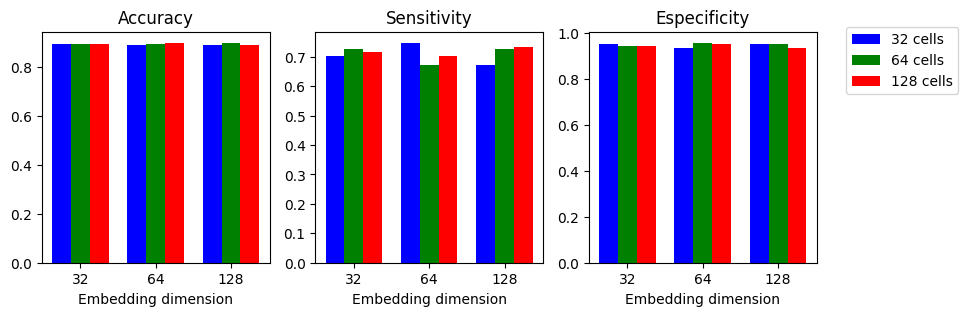

Best accuracy= 0.9008228670420095


In [34]:
from local.lib.DataPreparationRNN import Plot_sentiment_performance
Plot_sentiment_performance(sensitivity,accuracy,especificity)

## Task 3

Create a similar architecture to that of task 2, but in this case use global vectors (GloVe) from gensim library to set the Embedding weights. Set the Embedding layer as non trainable. If there is any missing word in the pre-trained GloVes, you can use the token 'unk' instead.

**Note**: Take care on the tokenization of the words. Keras tokenizer does not assign the zero value to any word because of padding purposes. Make sure that the order of the vectors in the GloVe embedding matrix corresponds with the indexes in the dictionary.

In [35]:
#Run this cell to get the pre-trained word embedding vectors
import gensim.downloader
glove_vectors = gensim.downloader.load('glove-twitter-50')

In [36]:
#Run this cell to provide the grader with the word embedding vectors
import pickle
with open('GloVe.pkl', 'wb') as output:
    pickle.dump(glove_vectors, output, pickle.HIGHEST_PROTOCOL)

In [43]:
def Recurrent_Model_TF(tokenizer,glove_vectors,cells_number = 10, layer_type='SimpleRNN'):#Options for layer_type: 'SimpleRNN', 'LSTM', 'GRU'
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Embedding, Masking, SimpleRNN, LSTM, GRU, Dense, Dropout
    import numpy as np

    max_words = 2000
    num_words = max_words + 1
    vocab_size = num_words
    embedding_dim = glove_vectors.vector_size
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, i in tokenizer.word_index.items():
          if i < num_words:
              if word in glove_vectors:
                  embedding_matrix[i] = glove_vectors[word]
              else:
                  embedding_matrix[i] = glove_vectors['unk']

    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],mask_zero=True, trainable=False))
    model.add(Masking(mask_value=0.0))

    if layer_type == 'SimpleRNN':
        rnn_layer = SimpleRNN(cells_number, activation ='relu')
    elif layer_type == 'LSTM':
        rnn_layer = LSTM(cells_number, activation ='tanh')
    elif layer_type == 'GRU':
        rnn_layer = GRU(cells_number, activation ='tanh')
    else:
        raise ValueError("Invalid layer_type. Please choose from 'SimpleRNN', 'LSTM', or 'GRU'.")

    model.add(rnn_layer)
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(1, activation='sigmoid'))

    return model

**Submit your solution:**

In [44]:
student.submit_task(namespace=globals(), task_id='T3');

### Let's test the model:

**Warning**: Run this part only if you have already passed Tasks 2 and 3.

In [45]:
sensitivity = np.zeros((3))
especificity = np.zeros((3))
accuracy = np.zeros((3))
for j,cells in enumerate([32,64,128]):
    model = Recurrent_Model_TF(tokenizer, glove_vectors, cells_number = cells, layer_type='LSTM')
    model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])
    model.fit(X_tr, y_tr, validation_split=0.1,batch_size=32, epochs=10, verbose=1)
    y_pred = np.round(model.predict(X_te))
    sensitivity = recall_score(y_te,y_pred)
    accuracy[j] = accuracy_score(y_te,y_pred)
    especificity[j] = especi_score(y_te,y_pred.flatten())

Epoch 1/10
260/260 [==============================] - 18s 22ms/step - loss: 0.3627 - accuracy: 0.8576 - val_loss: 0.2794 - val_accuracy: 0.8929
Epoch 2/10
260/260 [==============================] - 5s 20ms/step - loss: 0.2720 - accuracy: 0.8996 - val_loss: 0.2838 - val_accuracy: 0.8820
Epoch 3/10
260/260 [==============================] - 4s 17ms/step - loss: 0.2506 - accuracy: 0.9071 - val_loss: 0.2655 - val_accuracy: 0.8950
Epoch 4/10
260/260 [==============================] - 5s 19ms/step - loss: 0.2386 - accuracy: 0.9088 - val_loss: 0.2571 - val_accuracy: 0.8929
Epoch 5/10
260/260 [==============================] - 5s 21ms/step - loss: 0.2298 - accuracy: 0.9113 - val_loss: 0.2663 - val_accuracy: 0.8994
Epoch 6/10
260/260 [==============================] - 4s 15ms/step - loss: 0.2240 - accuracy: 0.9142 - val_loss: 0.2650 - val_accuracy: 0.8972
Epoch 7/10
260/260 [==============================] - 4s 16ms/step - loss: 0.2140 - accuracy: 0.9175 - val_loss: 0.2533 - val_accuracy: 0.901

Best accuracy= 0.9164140320485058


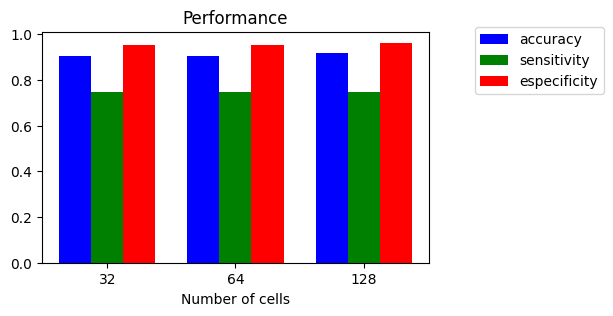

In [46]:
fig, ax = plt.subplots(figsize=(5,3))
X = np.arange(3)
ax.bar(X + 0.00, accuracy, color = 'b', width = 0.25)
ax.bar(X + 0.25, sensitivity, color = 'g', width = 0.25)
ax.bar(X + 0.50, especificity, color = 'r', width = 0.25)
ax.set_xticks([0.25, 1.25, 2.25])
ax.set_xticklabels(['32','64', '128'])
ax.set_title('Performance')
ax.set_xlabel('Number of cells')
ax.legend(labels=['accuracy','sensitivity','especificity'],bbox_to_anchor=(1.1, 1.05))
print('Best accuracy= {}'.format(np.max(accuracy)))

## Task 4

Create a function similar to that of task 3, but use a Conv1D layer instead of the LSTM one. The output of the Conv1D layer must keep the dimension related to the number of words per sentence unchanged. The number of filters (kernels) must be a functions' input parameter and define the kernels size in order for the model to use trigrams.  Let the rest of parameters with their default values. Use the GloVe embedding weights from the former task. To complete the architecture and shape correctly the tensors, you must use a GlobalMaxPooling1D layer after the CNN layer.

In [50]:
def Con1D_Model_TF(tokenizer, glove_vectors, filters = 10):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Masking
    import numpy as np

    max_words = 2000
    num_words = max_words + 1
    vocab_size = num_words
    embedding_dim = glove_vectors.vector_size
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, i in tokenizer.word_index.items():
        if i < num_words:
            if word in glove_vectors:
                embedding_matrix[i] = glove_vectors[word]
            else:
                embedding_matrix[i] = glove_vectors['unk']

    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], mask_zero=True, trainable=False))
    model.add(Masking(mask_value=0.0))
    model.add(Conv1D(filters=filters, kernel_size=3,  padding='same'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(10,  activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    return model

**Submit your solution:**

In [51]:
student.submit_task(namespace=globals(), task_id='T4');

### Let's test the model:

**Warning**: Run this part only if you have already passed Tasks 3 and 4.

In [52]:
sensitivity = np.zeros((3))
especificity = np.zeros((3))
accuracy = np.zeros((3))
for j,cells in enumerate([6,12,24]):
    model = Con1D_Model_TF(tokenizer, glove_vectors, filters = cells)
    model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])
    model.fit(X_tr, y_tr, validation_split=0.1,batch_size=32, epochs=10, verbose=1)
    y_pred = np.round(model.predict(X_te))
    sensitivity = recall_score(y_te,y_pred)
    accuracy[j] = accuracy_score(y_te,y_pred)
    especificity[j] = especi_score(y_te,y_pred.flatten())

Epoch 1/10
260/260 [==============================] - 2s 6ms/step - loss: 0.5957 - accuracy: 0.7056 - val_loss: 0.3405 - val_accuracy: 0.8723
Epoch 2/10
260/260 [==============================] - 2s 6ms/step - loss: 0.3365 - accuracy: 0.8742 - val_loss: 0.2881 - val_accuracy: 0.8853
Epoch 3/10
260/260 [==============================] - 2s 6ms/step - loss: 0.2970 - accuracy: 0.8895 - val_loss: 0.2795 - val_accuracy: 0.8874
Epoch 4/10
260/260 [==============================] - 1s 4ms/step - loss: 0.2746 - accuracy: 0.8983 - val_loss: 0.2719 - val_accuracy: 0.8918
Epoch 5/10
260/260 [==============================] - 1s 4ms/step - loss: 0.2674 - accuracy: 0.9027 - val_loss: 0.2674 - val_accuracy: 0.8972
Epoch 6/10
260/260 [==============================] - 1s 4ms/step - loss: 0.2583 - accuracy: 0.9044 - val_loss: 0.2689 - val_accuracy: 0.8929
Epoch 7/10
260/260 [==============================] - 1s 4ms/step - loss: 0.2481 - accuracy: 0.9117 - val_loss: 0.2679 - val_accuracy: 0.8950
Epoch 

Best accuracy= 0.9068860978778692


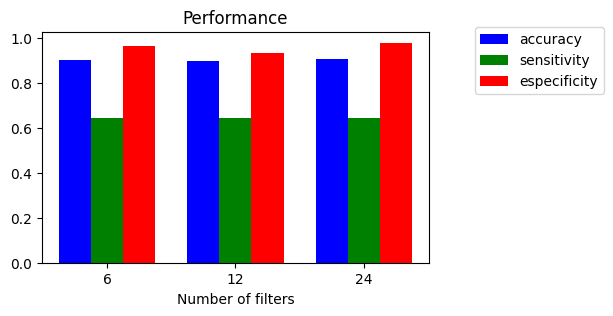

In [53]:
fig, ax = plt.subplots(figsize=(5,3))
X = np.arange(3)
ax.bar(X + 0.00, accuracy, color = 'b', width = 0.25)
ax.bar(X + 0.25, sensitivity, color = 'g', width = 0.25)
ax.bar(X + 0.50, especificity, color = 'r', width = 0.25)
ax.set_xticks([0.25, 1.25, 2.25])
ax.set_xticklabels(['6','12', '24'])
ax.set_title('Performance')
ax.set_xlabel('Number of filters')
ax.legend(labels=['accuracy','sensitivity','especificity'],bbox_to_anchor=(1.1, 1.05))
print('Best accuracy= {}'.format(np.max(accuracy)))